In [1]:
!pip install pyyaml==5.1

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
torch:  1.13 ; cuda:  1.13.1


In [2]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-t0u_e9lx
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-t0u_e9lx
  Resolved https://github.com/facebookresearch/detectron2.git to commit d4a5f28e01b2babbaba9f90198fb95f5c661cccd
  Preparing metadata (setup.py) ... done


In [3]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [4]:
import os

from detectron2.checkpoint import DetectionCheckpointer
from detectron2.config import get_cfg
from detectron2.engine import (
    default_argument_parser,
    default_setup,
    DefaultTrainer,
    launch,
)
from detectron2.evaluation import COCOEvaluator, PascalVOCDetectionEvaluator
from detectron2.layers import get_norm
from detectron2.modeling.roi_heads import Res5ROIHeads, ROI_HEADS_REGISTRY


In [5]:
class Trainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        if "coco" in dataset_name:
            return COCOEvaluator(dataset_name, cfg, True, output_folder)
        else:
            assert "voc" in dataset_name
            return PascalVOCDetectionEvaluator(dataset_name)

In [6]:
def setup():
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
    cfg.freeze()
    return cfg


In [7]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

In [8]:
cfg=setup()

In [9]:
cfg

CfgNode({'VERSION': 2, 'MODEL': CfgNode({'LOAD_PROPOSALS': False, 'MASK_ON': True, 'KEYPOINT_ON': False, 'DEVICE': 'cuda', 'META_ARCHITECTURE': 'GeneralizedRCNN', 'WEIGHTS': 'detectron2://ImageNetPretrained/MSRA/R-50.pkl', 'PIXEL_MEAN': [103.53, 116.28, 123.675], 'PIXEL_STD': [1.0, 1.0, 1.0], 'BACKBONE': CfgNode({'NAME': 'build_resnet_fpn_backbone', 'FREEZE_AT': 2}), 'FPN': CfgNode({'IN_FEATURES': ['res2', 'res3', 'res4', 'res5'], 'OUT_CHANNELS': 256, 'NORM': '', 'FUSE_TYPE': 'sum'}), 'PROPOSAL_GENERATOR': CfgNode({'NAME': 'RPN', 'MIN_SIZE': 0}), 'ANCHOR_GENERATOR': CfgNode({'NAME': 'DefaultAnchorGenerator', 'SIZES': [[32], [64], [128], [256], [512]], 'ASPECT_RATIOS': [[0.5, 1.0, 2.0]], 'ANGLES': [[-90, 0, 90]], 'OFFSET': 0.0}), 'RPN': CfgNode({'HEAD_NAME': 'StandardRPNHead', 'IN_FEATURES': ['p2', 'p3', 'p4', 'p5', 'p6'], 'BOUNDARY_THRESH': -1, 'IOU_THRESHOLDS': [0.3, 0.7], 'IOU_LABELS': [0, -1, 1], 'BATCH_SIZE_PER_IMAGE': 256, 'POSITIVE_FRACTION': 0.5, 'BBOX_REG_LOSS_TYPE': 'smooth_l1

In [10]:
model = Trainer.build_model(cfg)

[05/07 19:30:43 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [11]:
cfg.OUTPUT_DIR,cfg.MODEL.WEIGHTS

('./output', 'detectron2://ImageNetPretrained/MSRA/R-50.pkl')

In [36]:
model_weights="detection/best_converted.pth"
out_dir="."

In [28]:
checkpointer = DetectionCheckpointer(model)
checkpointer.load(model_weights)

[05/07 20:57:36 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from detection/best_converted.pth ...
[05/07 20:57:37 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone.bottom_up:
| Names in Model    | Names in Checkpoint                                                               | Shapes                                          |
|:------------------|:----------------------------------------------------------------------------------|:------------------------------------------------|
| res2.0.conv1.*    | res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| res2.0.conv2.*    | res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| res2.0.conv3.*    | res2.0.conv3.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (256,) (256,) (256,) (256,) (256,64,1

Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.deconv.{bias, weight}
roi_heads.mask_head.mask_fcn1.{bias, weight}
roi_heads.mask_head.mask_fcn2.{bias, weight}
roi_heads.mask_head.mask_fcn3.{bias, weight}
roi_heads.mask_head.mask_fcn4.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}
The checkpoint state_dict contains 

{'__author__': 'MOCO', 'matching_heuristics': True}

In [29]:

import os
import numpy as np
import json
from detectron2.structures import BoxMode

def get_balloon_dicts(img_dir):
    json_file = os.path.join(img_dir, "via_region_data.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}
        
        filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
    
      
        annos = v["regions"]
        objs = []
        for _, anno in annos.items():
            assert not anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

for d in ["train", "val"]:
    DatasetCatalog.register("balloon_" + d, lambda d=d: get_balloon_dicts("balloon/" + d))
    MetadataCatalog.get("balloon_" + d).set(thing_classes=["balloon"])
balloon_metadata = MetadataCatalog.get("balloon_train")

AssertionError: Dataset 'balloon_train' is already registered!

In [30]:
import random
dataset_dicts = get_balloon_dicts("balloon/train")

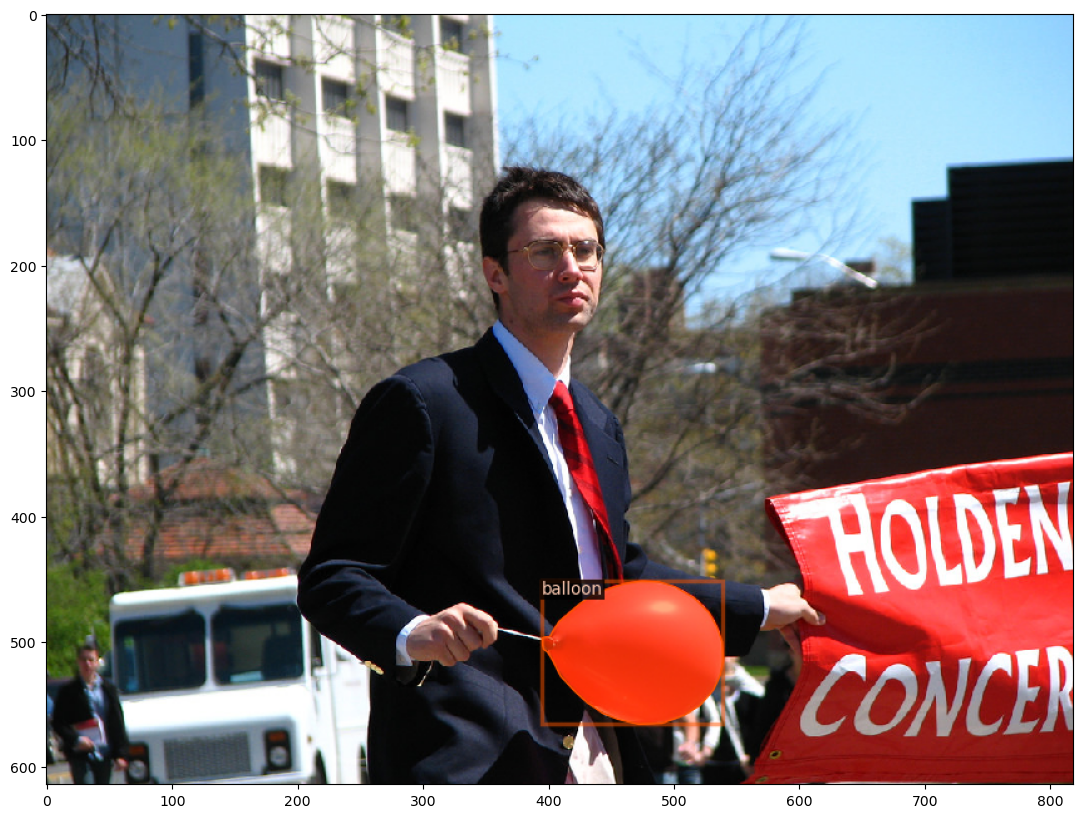

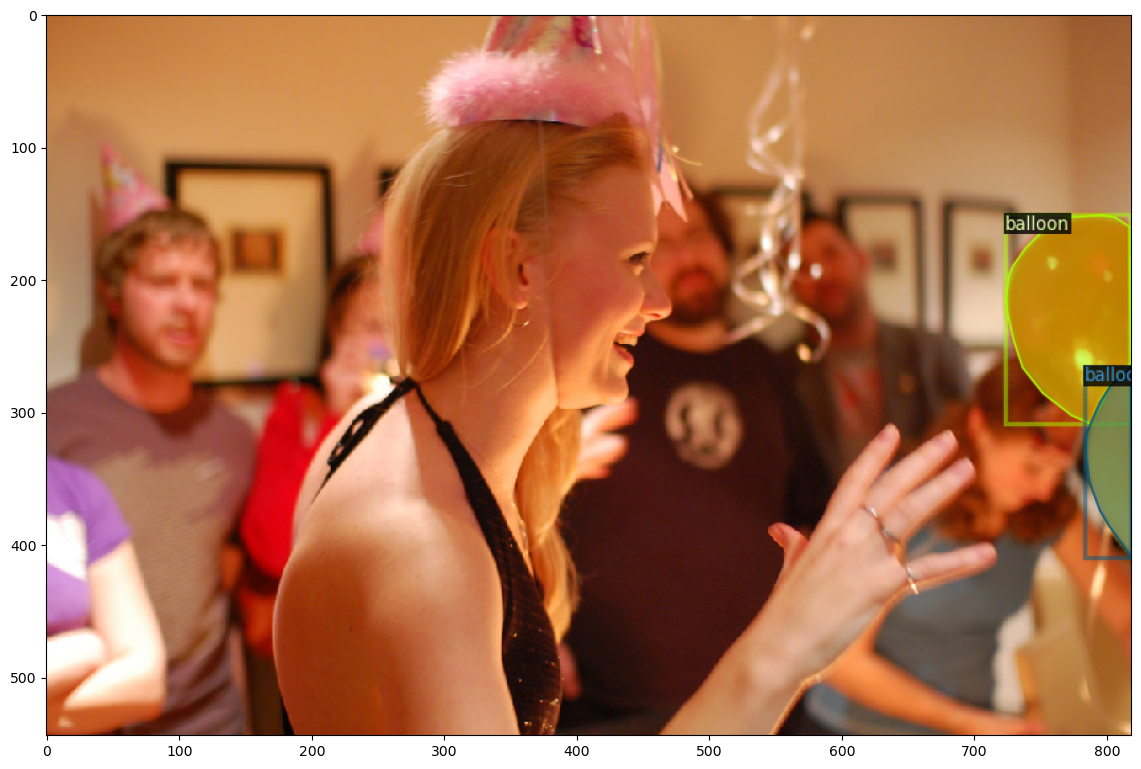

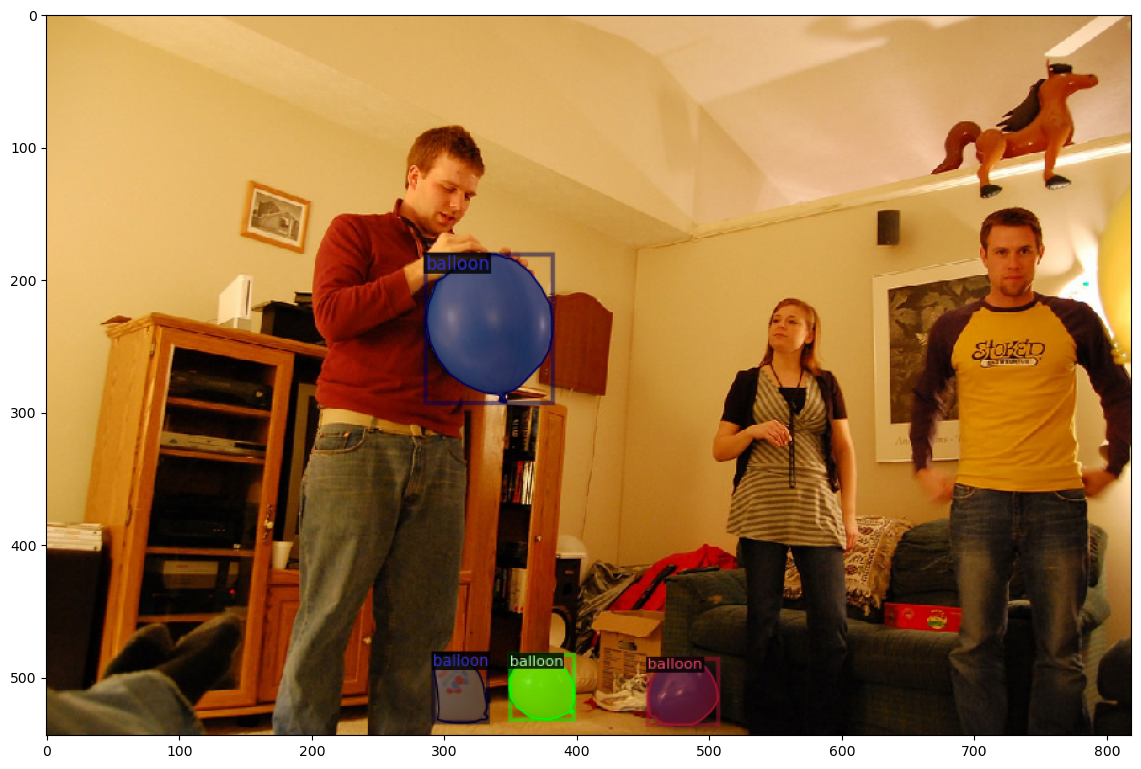

In [31]:
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    v = Visualizer(im[:, :, ::-1], metadata=balloon_metadata, scale=0.8)
    v = v.draw_dataset_dict(d)
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

In [58]:
from detectron2.utils.analysis import  flop_count_operators
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode
from detectron2.engine import DefaultTrainer
from detectron2.utils.visualizer import ColorMode
from scipy.spatial import distance
from detectron2.evaluation import inference_on_dataset
from detectron2.evaluation import DatasetEvaluator
import detectron2.utils.logger as logger
from detectron2.engine.hooks import HookBase
from detectron2.evaluation import inference_context
from detectron2.data import DatasetMapper, build_detection_test_loader
import detectron2.utils.comm as comm
from detectron2.data import DatasetMapper, build_detection_test_loader
import detectron2.data.detection_utils as mapperutils
import detectron2.data.transforms as mapperT
from detectron2.evaluation import COCOEvaluator

class LossEvalHook(HookBase):
    """Hook Class for Calculating Evaluation

    Args:
        HookBase ([type]): Hooks for training intermediate output
    """

    def __init__(self, cfg, model, data_loader):
        self.cfg=cfg
        self._period = self.cfg.TEST.EVAL_PERIOD
        self._data_loader = data_loader
        self.predictor = DefaultPredictor(cfg)
        self.predictor.model=model
        self.calculate_flops=True
        #self.cls_meta = cfg.DATASETS.METADATAINFO
        assert id(self.predictor.model)==id(model)

    def _do_loss_eval(self):
        losses = []
        with torch.no_grad():
            for idx, inputs in enumerate(self._data_loader):
                if torch.cuda.is_available():
                    torch.cuda.synchronize()
                loss_batch = self._get_loss(inputs)
                losses.append(loss_batch)
            mean_loss = np.mean(losses)
            logger.logging.info(f"Mean Validation loss {mean_loss}")
            self.trainer.storage.put_scalar("Validation_Loss", mean_loss)
            comm.synchronize()
        return losses
    
    
    def vis_images(self,num_images=20):
        # set model to eval
        self.predictor.model.eval()
        log_counter = 0
        for idx, inputs in enumerate(self._data_loader):
            img=inputs[0]["image"].permute(1,2,0).detach().to("cpu").numpy()
            img=img.copy()
            outputs = self.predictor(img) 
            v = Visualizer(img[:, :, ::-1],
                            metadata=None, 
                            scale=0.5, 
                            instance_mode=ColorMode.IMAGE_BW   
                )
            out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
            log_counter += 1
            #out.get_image()
            if idx>=num_images:
                break
        #set back to train
        self.predictor.model.train()
        

    def _get_loss(self, data):
        # How loss is calculated on train_loop
        metrics_dict = self.predictor.model(data)
        metrics_dict = {
            k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v)
            for k, v in metrics_dict.items()
        }
        total_losses_reduced = sum(loss for loss in metrics_dict.values())
        return total_losses_reduced
    
    def get_flops(self):
        # Take one batch
        inputs= next(iter(self._data_loader))
        flops=flop_count_operators(self.predictor.model,inputs)
        return flops
    
    def after_step(self):
        next_iter = self.trainer.iter + 1
        is_final = next_iter == self.trainer.max_iter
        if self.calculate_flops:
            flps=self.get_flops()
            total=0
            for k,v in flps.items():
                total+=v
            # total has flops
            self.calculate_flops=False
            
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            self._do_loss_eval()
            logger.logging.info(f"Validation Bbox AP {self.trainer.storage.history("bbox/AP").latest()}")
            logger.logging.info(f"Validation Segmentation AP {self.trainer.storage.history("segm/AP").latest()}")
            self.vis_images()



class LossTrainHook(HookBase):
    """Hook Class for Calculating Evaluation

    Args:
        HookBase ([type]): Hooks for training intermediate output
    """

    def __init__(self,period):
        self._period=period

    def after_step(self):
        next_iter = self.trainer.iter + 1
        is_final = next_iter == self.trainer.max_iter
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            train_loss=self.trainer.storage.history("total_loss").median(20)
            #if self.wab:
            #    self.wab.log({"Train Loss": train_loss})


class InstanceTrainer(DefaultTrainer):
    """Create a trainer for veg datasets

    Args:
        DefaultTrainer ([type]): Default trainer from detectron2

    Returns:
        [type]: [description]
    """
    def __init__(self,cfg):
        super().__init__(cfg)
        
    
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name,output_dir=cfg.OUTPUT_DIR)

    def build_hooks(self):
        hooks = super().build_hooks()
        # Build mapper Augmentations by passing the test mode but pass the test mode=False in mapper to get the labels finally replace the augm list with the 
        #  test one a workaround to not change the mapper class 
        augs=mapperutils.build_augmentation(self.cfg, is_train=False)
        augsList=mapperT.AugmentationList(augs)
        val_mapper=DatasetMapper(self.cfg, True)
        val_mapper.augmentations=augsList
          
        hooks.insert(
            -1,
            LossEvalHook(
                self.cfg,
                self.model,
                build_detection_test_loader(self.cfg, self.cfg.DATASETS.TEST[0], val_mapper),
            ),
        )
        hooks.insert(
            -1,
            LossTrainHook(self.cfg.TRAINLOG)
        )
        return hooks

In [59]:
import yaml
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("balloon_train",)
cfg.DATASETS.TEST = ("balloon_val",)
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_weights
# cfg["INPUT"]["MASK_FORMAT"]='bitmask'
cfg["INPUT"]["RANDOM_FLIP"] = "horizontal"
cfg["INPUT"]["ROTATE"] = [-2.0, 2.0]
cfg["INPUT"]["LIGHT_SCALE"] = 1.1
cfg["INPUT"]["Brightness_SCALE"] = [0.9, 1.1]
cfg["INPUT"]["Contrast_SCALE"] = [0.9, 1.1]
cfg["INPUT"]["Saturation_SCALE"] = [0.9, 1.1]
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 1e-4  # pick a good LR
cfg.SOLVER.CHECKPOINT_PERIOD = 1000
cfg.SOLVER.MAX_ITER = 10000  
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 1024  # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.MODEL.SEM_SEG_HEAD.NUM_CLASSES = 1
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1
cfg.TEST.EVAL_PERIOD=1000
cfg.OUTPUT_DIR=out_dir
os.makedirs(cfg.OUTPUT_DIR ,exist_ok=True)
# New configs
cfg.set_new_allowed(True)
cfg.TRAINLOG=100
cfg_dict=yaml.load(cfg.dump())
# save all the configs for prediction
with open(os.path.join(cfg.OUTPUT_DIR,"pred_config.yaml"), 'w') as file:
    file.write(cfg.dump())

/tmp/ipykernel_24962/2531236509.py:29: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  cfg_dict=yaml.load(cfg.dump())


In [60]:
trainer = InstanceTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[05/07 21:03:15 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[05/07 21:03:17 d2.data.build]: Removed 0 images with no usable annotations. 61 images left.
[05/07 21:03:17 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[05/07 21:03:17 d2.data.build]: Using training sampler TrainingSampler
[05/07 21:03:17 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/07 21:03:17 d2.data.common]: Serializing 61 elements to byte tensors and concatenating them all ...
[05/07 21:03:17 d2.data.common]: Serialized dataset takes 0.17 MiB
WARNING [05/07 21:03:17 d2.solver.build]: SOLVER.STEPS contains values larger than SOLVER.MAX_ITER. These values will be ignored.
[05/07 21:03:17 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomF

Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.deconv.{bias, weight}
roi_heads.mask_head.mask_fcn1.{bias, weight}
roi_heads.mask_head.mask_fcn2.{bias, weight}
roi_heads.mask_head.mask_fcn3.{bias, weight}
roi_heads.mask_head.mask_fcn4.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}
The checkpoint state_dict contains 

[05/07 21:03:19 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from detection/best_converted.pth ...
[05/07 21:03:20 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone.bottom_up:
| Names in Model    | Names in Checkpoint                                                               | Shapes                                          |
|:------------------|:----------------------------------------------------------------------------------|:------------------------------------------------|
| res2.0.conv1.*    | res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| res2.0.conv2.*    | res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| res2.0.conv3.*    | res2.0.conv3.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (256,) (256,) (256,) (256,) (256,64,1

Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.deconv.{bias, weight}
roi_heads.mask_head.mask_fcn1.{bias, weight}
roi_heads.mask_head.mask_fcn2.{bias, weight}
roi_heads.mask_head.mask_fcn3.{bias, weight}
roi_heads.mask_head.mask_fcn4.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}
The checkpoint state_dict contains 

[05/07 21:03:20 d2.engine.train_loop]: Starting training from iteration 0


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525539683/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Unsupported operator prim::CallFunction encountered 24 time(s)
Unsupported operator aten::pad encountered 1 time(s)
Unsupported operator aten::topk encountered 5 time(s)
Unsupported operator torchvision::roi_align encountered 8 time(s)


[05/07 21:04:39 d2.utils.events]:  eta: 0:33:28  iter: 19  total_loss: 50.57  loss_cls: 21.24  loss_box_reg: 7.797  loss_mask: 1.592  loss_rpn_cls: 6.514  loss_rpn_loc: 9.299    time: 0.1968  last_time: 0.2073  data_time: 0.0190  last_data_time: 0.0034   lr: 1.9981e-06  max_mem: 2894M
[05/07 21:04:45 d2.utils.events]:  eta: 0:34:43  iter: 39  total_loss: 10.43  loss_cls: 4.259  loss_box_reg: 2.523  loss_mask: 1.299  loss_rpn_cls: 0.5949  loss_rpn_loc: 2.327    time: 0.2093  last_time: 0.2460  data_time: 0.0053  last_data_time: 0.0030   lr: 3.9961e-06  max_mem: 3104M
[05/07 21:04:49 d2.utils.events]:  eta: 0:35:34  iter: 59  total_loss: 4.394  loss_cls: 1.368  loss_box_reg: 0.3131  loss_mask: 0.939  loss_rpn_cls: 0.5019  loss_rpn_loc: 1.123    time: 0.2157  last_time: 0.2286  data_time: 0.0051  last_data_time: 0.0045   lr: 5.9941e-06  max_mem: 3104M
[05/07 21:04:54 d2.utils.events]:  eta: 0:36:22  iter: 79  total_loss: 3.181  loss_cls: 0.6295  loss_box_reg: 0.134  loss_mask: 0.7685  los

[05/07 21:06:41 d2.utils.events]:  eta: 0:33:27  iter: 579  total_loss: 1.028  loss_cls: 0.1254  loss_box_reg: 0.06807  loss_mask: 0.5869  loss_rpn_cls: 0.116  loss_rpn_loc: 0.0359    time: 0.2143  last_time: 0.1657  data_time: 0.0057  last_data_time: 0.0051   lr: 5.7942e-05  max_mem: 3104M
[05/07 21:06:45 d2.utils.events]:  eta: 0:33:21  iter: 599  total_loss: 0.9307  loss_cls: 0.1253  loss_box_reg: 0.07289  loss_mask: 0.5909  loss_rpn_cls: 0.08708  loss_rpn_loc: 0.03021    time: 0.2141  last_time: 0.2302  data_time: 0.0057  last_data_time: 0.0080   lr: 5.994e-05  max_mem: 3104M
[05/07 21:06:49 d2.utils.events]:  eta: 0:33:13  iter: 619  total_loss: 0.9136  loss_cls: 0.1268  loss_box_reg: 0.0725  loss_mask: 0.5589  loss_rpn_cls: 0.1078  loss_rpn_loc: 0.05165    time: 0.2137  last_time: 0.2191  data_time: 0.0052  last_data_time: 0.0072   lr: 6.1938e-05  max_mem: 3104M
[05/07 21:06:53 d2.utils.events]:  eta: 0:33:08  iter: 639  total_loss: 1.088  loss_cls: 0.2336  loss_box_reg: 0.1314  

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[05/07 21:08:13 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[05/07 21:08:13 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.01 seconds.
[05/07 21:08:13 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[05/07 21:08:13 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.01 seconds.
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Avera

[05/07 21:09:18 d2.utils.events]:  eta: 0:30:29  iter: 1299  total_loss: 0.9102  loss_cls: 0.1195  loss_box_reg: 0.08434  loss_mask: 0.55  loss_rpn_cls: 0.09301  loss_rpn_loc: 0.03924    time: 0.2122  last_time: 0.1973  data_time: 0.0057  last_data_time: 0.0053   lr: 0.0001  max_mem: 3105M
[05/07 21:09:22 d2.utils.events]:  eta: 0:30:24  iter: 1319  total_loss: 0.7149  loss_cls: 0.08442  loss_box_reg: 0.0578  loss_mask: 0.4939  loss_rpn_cls: 0.06293  loss_rpn_loc: 0.01776    time: 0.2121  last_time: 0.2119  data_time: 0.0053  last_data_time: 0.0065   lr: 0.0001  max_mem: 3105M
[05/07 21:09:26 d2.utils.events]:  eta: 0:30:21  iter: 1339  total_loss: 0.804  loss_cls: 0.07851  loss_box_reg: 0.05676  loss_mask: 0.5108  loss_rpn_cls: 0.07703  loss_rpn_loc: 0.01919    time: 0.2122  last_time: 0.2249  data_time: 0.0054  last_data_time: 0.0045   lr: 0.0001  max_mem: 3105M
[05/07 21:09:31 d2.utils.events]:  eta: 0:30:15  iter: 1359  total_loss: 0.8289  loss_cls: 0.1049  loss_box_reg: 0.07378  l

[05/07 21:11:17 d2.utils.events]:  eta: 0:28:36  iter: 1859  total_loss: 0.7702  loss_cls: 0.1038  loss_box_reg: 0.08425  loss_mask: 0.4903  loss_rpn_cls: 0.05269  loss_rpn_loc: 0.03085    time: 0.2122  last_time: 0.2292  data_time: 0.0057  last_data_time: 0.0053   lr: 0.0001  max_mem: 3105M
[05/07 21:11:21 d2.utils.events]:  eta: 0:28:34  iter: 1879  total_loss: 0.7808  loss_cls: 0.08968  loss_box_reg: 0.06043  loss_mask: 0.4654  loss_rpn_cls: 0.06022  loss_rpn_loc: 0.03597    time: 0.2122  last_time: 0.1977  data_time: 0.0057  last_data_time: 0.0076   lr: 0.0001  max_mem: 3105M
[05/07 21:11:26 d2.utils.events]:  eta: 0:28:30  iter: 1899  total_loss: 0.6677  loss_cls: 0.07067  loss_box_reg: 0.06897  loss_mask: 0.4487  loss_rpn_cls: 0.05137  loss_rpn_loc: 0.01547    time: 0.2122  last_time: 0.2115  data_time: 0.0055  last_data_time: 0.0047   lr: 0.0001  max_mem: 3105M
[05/07 21:11:30 d2.utils.events]:  eta: 0:28:26  iter: 1919  total_loss: 0.7066  loss_cls: 0.08899  loss_box_reg: 0.084

[05/07 21:12:11 d2.utils.events]:  eta: 0:27:56  iter: 2059  total_loss: 0.6982  loss_cls: 0.07792  loss_box_reg: 0.06605  loss_mask: 0.4674  loss_rpn_cls: 0.05155  loss_rpn_loc: 0.02349    time: 0.2122  last_time: 0.2159  data_time: 0.0053  last_data_time: 0.0013   lr: 0.0001  max_mem: 4293M
[05/07 21:12:15 d2.utils.events]:  eta: 0:27:52  iter: 2079  total_loss: 0.6847  loss_cls: 0.09624  loss_box_reg: 0.07597  loss_mask: 0.4394  loss_rpn_cls: 0.05361  loss_rpn_loc: 0.02174    time: 0.2121  last_time: 0.2066  data_time: 0.0066  last_data_time: 0.0087   lr: 0.0001  max_mem: 4293M
[05/07 21:12:19 d2.utils.events]:  eta: 0:27:46  iter: 2099  total_loss: 0.7616  loss_cls: 0.07645  loss_box_reg: 0.07125  loss_mask: 0.4838  loss_rpn_cls: 0.05609  loss_rpn_loc: 0.02139    time: 0.2121  last_time: 0.2219  data_time: 0.0064  last_data_time: 0.0057   lr: 0.0001  max_mem: 4293M
[05/07 21:12:24 d2.utils.events]:  eta: 0:27:43  iter: 2119  total_loss: 0.9209  loss_cls: 0.1117  loss_box_reg: 0.107

[05/07 21:14:13 d2.utils.events]:  eta: 0:26:18  iter: 2619  total_loss: 0.6668  loss_cls: 0.08683  loss_box_reg: 0.09196  loss_mask: 0.4294  loss_rpn_cls: 0.04374  loss_rpn_loc: 0.02237    time: 0.2131  last_time: 0.1971  data_time: 0.0053  last_data_time: 0.0047   lr: 0.0001  max_mem: 4293M
[05/07 21:14:17 d2.utils.events]:  eta: 0:26:14  iter: 2639  total_loss: 0.6091  loss_cls: 0.08402  loss_box_reg: 0.0841  loss_mask: 0.4288  loss_rpn_cls: 0.04609  loss_rpn_loc: 0.02551    time: 0.2132  last_time: 0.2075  data_time: 0.0059  last_data_time: 0.0020   lr: 0.0001  max_mem: 4293M
[05/07 21:14:21 d2.utils.events]:  eta: 0:26:10  iter: 2659  total_loss: 0.706  loss_cls: 0.07679  loss_box_reg: 0.08844  loss_mask: 0.447  loss_rpn_cls: 0.03766  loss_rpn_loc: 0.01981    time: 0.2132  last_time: 0.2020  data_time: 0.0059  last_data_time: 0.0062   lr: 0.0001  max_mem: 4293M
[05/07 21:14:26 d2.utils.events]:  eta: 0:26:06  iter: 2679  total_loss: 0.5854  loss_cls: 0.07538  loss_box_reg: 0.08719

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[05/07 21:15:40 d2.evaluation.fast_eval_api]: Evaluate annotation type *segm*
[05/07 21:15:40 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.01 seconds.
[05/07 21:15:40 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[05/07 21:15:40 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.00 seconds.
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.069
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.119
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.065
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.130
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.074
 Avera

[05/07 21:17:09 d2.utils.events]:  eta: 0:23:41  iter: 3399  total_loss: 0.7015  loss_cls: 0.07157  loss_box_reg: 0.07669  loss_mask: 0.4219  loss_rpn_cls: 0.03091  loss_rpn_loc: 0.01577    time: 0.2139  last_time: 0.2299  data_time: 0.0054  last_data_time: 0.0036   lr: 0.0001  max_mem: 4293M
[05/07 21:17:13 d2.utils.events]:  eta: 0:23:35  iter: 3419  total_loss: 0.6528  loss_cls: 0.09125  loss_box_reg: 0.09998  loss_mask: 0.3917  loss_rpn_cls: 0.0366  loss_rpn_loc: 0.02362    time: 0.2139  last_time: 0.2173  data_time: 0.0058  last_data_time: 0.0097   lr: 0.0001  max_mem: 4293M
[05/07 21:17:17 d2.utils.events]:  eta: 0:23:32  iter: 3439  total_loss: 0.7007  loss_cls: 0.0833  loss_box_reg: 0.1043  loss_mask: 0.4188  loss_rpn_cls: 0.03963  loss_rpn_loc: 0.02499    time: 0.2139  last_time: 0.2064  data_time: 0.0054  last_data_time: 0.0030   lr: 0.0001  max_mem: 4293M
[05/07 21:17:22 d2.utils.events]:  eta: 0:23:24  iter: 3459  total_loss: 0.5843  loss_cls: 0.06499  loss_box_reg: 0.07479

[05/07 21:19:12 d2.utils.events]:  eta: 0:21:47  iter: 3959  total_loss: 0.5718  loss_cls: 0.06875  loss_box_reg: 0.07826  loss_mask: 0.3442  loss_rpn_cls: 0.03543  loss_rpn_loc: 0.01721    time: 0.2146  last_time: 0.2034  data_time: 0.0063  last_data_time: 0.0070   lr: 0.0001  max_mem: 4293M
[05/07 21:19:16 d2.utils.events]:  eta: 0:21:44  iter: 3979  total_loss: 0.6806  loss_cls: 0.08227  loss_box_reg: 0.09533  loss_mask: 0.4042  loss_rpn_cls: 0.04821  loss_rpn_loc: 0.02459    time: 0.2146  last_time: 0.2187  data_time: 0.0055  last_data_time: 0.0084   lr: 0.0001  max_mem: 4293M
[05/07 21:19:22 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/07 21:19:22 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/07 21:19:22 d2.data.common]: Serializing 13 elements to byte tensors and concatenating them all ...
[05/07 21:1

[05/07 21:20:02 d2.utils.events]:  eta: 0:21:08  iter: 4159  total_loss: 0.481  loss_cls: 0.0615  loss_box_reg: 0.06728  loss_mask: 0.2955  loss_rpn_cls: 0.02955  loss_rpn_loc: 0.01732    time: 0.2149  last_time: 0.2338  data_time: 0.0054  last_data_time: 0.0052   lr: 0.0001  max_mem: 4293M
[05/07 21:20:07 d2.utils.events]:  eta: 0:21:03  iter: 4179  total_loss: 0.5513  loss_cls: 0.06975  loss_box_reg: 0.08717  loss_mask: 0.3487  loss_rpn_cls: 0.02464  loss_rpn_loc: 0.01927    time: 0.2149  last_time: 0.2016  data_time: 0.0066  last_data_time: 0.0054   lr: 0.0001  max_mem: 4293M
[05/07 21:20:11 d2.utils.events]:  eta: 0:20:59  iter: 4199  total_loss: 0.5761  loss_cls: 0.06665  loss_box_reg: 0.09399  loss_mask: 0.3442  loss_rpn_cls: 0.02503  loss_rpn_loc: 0.02705    time: 0.2149  last_time: 0.2068  data_time: 0.0053  last_data_time: 0.0032   lr: 0.0001  max_mem: 4293M
[05/07 21:20:15 d2.utils.events]:  eta: 0:20:55  iter: 4219  total_loss: 0.7294  loss_cls: 0.08634  loss_box_reg: 0.1264

[05/07 21:22:06 d2.utils.events]:  eta: 0:19:10  iter: 4719  total_loss: 0.6031  loss_cls: 0.07438  loss_box_reg: 0.1124  loss_mask: 0.3383  loss_rpn_cls: 0.02181  loss_rpn_loc: 0.02154    time: 0.2155  last_time: 0.1935  data_time: 0.0050  last_data_time: 0.0048   lr: 0.0001  max_mem: 4293M
[05/07 21:22:11 d2.utils.events]:  eta: 0:19:06  iter: 4739  total_loss: 0.6039  loss_cls: 0.08037  loss_box_reg: 0.1104  loss_mask: 0.34  loss_rpn_cls: 0.02445  loss_rpn_loc: 0.01792    time: 0.2156  last_time: 0.3602  data_time: 0.0051  last_data_time: 0.0060   lr: 0.0001  max_mem: 4293M
[05/07 21:22:15 d2.utils.events]:  eta: 0:19:04  iter: 4759  total_loss: 0.6833  loss_cls: 0.09356  loss_box_reg: 0.1379  loss_mask: 0.3851  loss_rpn_cls: 0.0307  loss_rpn_loc: 0.02793    time: 0.2157  last_time: 0.2422  data_time: 0.0052  last_data_time: 0.0045   lr: 0.0001  max_mem: 4293M
[05/07 21:22:20 d2.utils.events]:  eta: 0:19:00  iter: 4779  total_loss: 0.557  loss_cls: 0.07077  loss_box_reg: 0.08133  lo

[05/07 21:23:13 d2.engine.defaults]: Evaluation results for balloon_val in csv format:
[05/07 21:23:13 d2.evaluation.testing]: copypaste: Task: bbox
[05/07 21:23:13 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[05/07 21:23:13 d2.evaluation.testing]: copypaste: 7.2649,17.5797,6.6581,0.0000,0.0000,12.2362
[05/07 21:23:13 d2.evaluation.testing]: copypaste: Task: segm
[05/07 21:23:13 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[05/07 21:23:13 d2.evaluation.testing]: copypaste: 8.6377,16.6216,8.6083,0.0000,0.0000,15.8084
[05/07 21:23:15 d2.utils.events]:  eta: 0:18:12  iter: 4999  total_loss: 0.6182  loss_cls: 0.06266  loss_box_reg: 0.09733  loss_mask: 0.3949  loss_rpn_cls: 0.02916  loss_rpn_loc: 0.01698    time: 0.2159  last_time: 0.1829  data_time: 0.0053  last_data_time: 0.0032   lr: 0.0001  max_mem: 4293M
[05/07 21:23:19 d2.utils.events]:  eta: 0:18:07  iter: 5019  total_loss: 0.4555  loss_cls: 0.05634  loss_box_reg: 0.06596  loss_mask: 0.3031  loss_rpn_cl

[05/07 21:25:11 d2.utils.events]:  eta: 0:16:26  iter: 5519  total_loss: 0.4291  loss_cls: 0.05716  loss_box_reg: 0.06314  loss_mask: 0.2835  loss_rpn_cls: 0.02092  loss_rpn_loc: 0.01547    time: 0.2165  last_time: 0.2346  data_time: 0.0055  last_data_time: 0.0064   lr: 0.0001  max_mem: 4293M
[05/07 21:25:15 d2.utils.events]:  eta: 0:16:22  iter: 5539  total_loss: 0.4211  loss_cls: 0.05369  loss_box_reg: 0.06089  loss_mask: 0.2951  loss_rpn_cls: 0.01769  loss_rpn_loc: 0.01196    time: 0.2166  last_time: 0.2190  data_time: 0.0053  last_data_time: 0.0052   lr: 0.0001  max_mem: 4293M
[05/07 21:25:20 d2.utils.events]:  eta: 0:16:19  iter: 5559  total_loss: 0.6766  loss_cls: 0.08743  loss_box_reg: 0.1303  loss_mask: 0.3903  loss_rpn_cls: 0.02483  loss_rpn_loc: 0.02403    time: 0.2166  last_time: 0.2391  data_time: 0.0075  last_data_time: 0.0079   lr: 0.0001  max_mem: 4293M
[05/07 21:25:24 d2.utils.events]:  eta: 0:16:14  iter: 5579  total_loss: 0.5033  loss_cls: 0.06097  loss_box_reg: 0.091

[05/07 21:27:03 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[05/07 21:27:03 d2.evaluation.coco_evaluation]: Saving results to ./coco_instances_results.json
[05/07 21:27:03 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[05/07 21:27:03 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[05/07 21:27:03 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.01 seconds.
[05/07 21:27:03 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[05/07 21:27:03 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.00 seconds.
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.099
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.219
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.078
 Average Precision  (AP) @[ IoU=0.50:0.95 | a

[05/07 21:28:04 d2.utils.events]:  eta: 0:13:50  iter: 6259  total_loss: 0.5881  loss_cls: 0.07726  loss_box_reg: 0.09131  loss_mask: 0.3594  loss_rpn_cls: 0.02043  loss_rpn_loc: 0.01663    time: 0.2174  last_time: 0.2333  data_time: 0.0054  last_data_time: 0.0049   lr: 0.0001  max_mem: 4293M
[05/07 21:28:08 d2.utils.events]:  eta: 0:13:45  iter: 6279  total_loss: 0.6143  loss_cls: 0.1007  loss_box_reg: 0.08518  loss_mask: 0.3836  loss_rpn_cls: 0.02706  loss_rpn_loc: 0.01859    time: 0.2174  last_time: 0.2241  data_time: 0.0055  last_data_time: 0.0032   lr: 0.0001  max_mem: 4293M
[05/07 21:28:12 d2.utils.events]:  eta: 0:13:41  iter: 6299  total_loss: 0.4337  loss_cls: 0.06337  loss_box_reg: 0.07863  loss_mask: 0.2822  loss_rpn_cls: 0.02277  loss_rpn_loc: 0.01862    time: 0.2175  last_time: 0.2385  data_time: 0.0055  last_data_time: 0.0030   lr: 0.0001  max_mem: 4293M
[05/07 21:28:17 d2.utils.events]:  eta: 0:13:37  iter: 6319  total_loss: 0.6087  loss_cls: 0.08741  loss_box_reg: 0.124

[05/07 21:30:10 d2.utils.events]:  eta: 0:11:48  iter: 6819  total_loss: 0.567  loss_cls: 0.08381  loss_box_reg: 0.1206  loss_mask: 0.3381  loss_rpn_cls: 0.01786  loss_rpn_loc: 0.02946    time: 0.2180  last_time: 0.2191  data_time: 0.0053  last_data_time: 0.0056   lr: 0.0001  max_mem: 4293M
[05/07 21:30:14 d2.utils.events]:  eta: 0:11:43  iter: 6839  total_loss: 0.3522  loss_cls: 0.04477  loss_box_reg: 0.07459  loss_mask: 0.1973  loss_rpn_cls: 0.01681  loss_rpn_loc: 0.01512    time: 0.2180  last_time: 0.2176  data_time: 0.0054  last_data_time: 0.0031   lr: 0.0001  max_mem: 4293M
[05/07 21:30:19 d2.utils.events]:  eta: 0:11:39  iter: 6859  total_loss: 0.5859  loss_cls: 0.06423  loss_box_reg: 0.129  loss_mask: 0.3403  loss_rpn_cls: 0.02145  loss_rpn_loc: 0.0211    time: 0.2180  last_time: 0.2630  data_time: 0.0055  last_data_time: 0.0037   lr: 0.0001  max_mem: 4293M
[05/07 21:30:23 d2.utils.events]:  eta: 0:11:34  iter: 6879  total_loss: 0.5017  loss_cls: 0.06155  loss_box_reg: 0.09608  

[05/07 21:31:01 d2.utils.events]:  eta: 0:11:03  iter: 7019  total_loss: 0.3652  loss_cls: 0.04354  loss_box_reg: 0.06773  loss_mask: 0.2395  loss_rpn_cls: 0.01897  loss_rpn_loc: 0.01439    time: 0.2182  last_time: 0.2148  data_time: 0.0056  last_data_time: 0.0047   lr: 0.0001  max_mem: 4293M
[05/07 21:31:06 d2.utils.events]:  eta: 0:10:58  iter: 7039  total_loss: 0.5352  loss_cls: 0.06514  loss_box_reg: 0.12  loss_mask: 0.3068  loss_rpn_cls: 0.01866  loss_rpn_loc: 0.02312    time: 0.2182  last_time: 0.2224  data_time: 0.0054  last_data_time: 0.0047   lr: 0.0001  max_mem: 4293M
[05/07 21:31:10 d2.utils.events]:  eta: 0:10:54  iter: 7059  total_loss: 0.4726  loss_cls: 0.04961  loss_box_reg: 0.07688  loss_mask: 0.3171  loss_rpn_cls: 0.01353  loss_rpn_loc: 0.01799    time: 0.2182  last_time: 0.1811  data_time: 0.0056  last_data_time: 0.0047   lr: 0.0001  max_mem: 4293M
[05/07 21:31:15 d2.utils.events]:  eta: 0:10:50  iter: 7079  total_loss: 0.5042  loss_cls: 0.06816  loss_box_reg: 0.1272 

[05/07 21:33:08 d2.utils.events]:  eta: 0:08:59  iter: 7579  total_loss: 0.4563  loss_cls: 0.06791  loss_box_reg: 0.08707  loss_mask: 0.2785  loss_rpn_cls: 0.01395  loss_rpn_loc: 0.01438    time: 0.2188  last_time: 0.2551  data_time: 0.0057  last_data_time: 0.0014   lr: 0.0001  max_mem: 4293M
[05/07 21:33:13 d2.utils.events]:  eta: 0:08:54  iter: 7599  total_loss: 0.5268  loss_cls: 0.06519  loss_box_reg: 0.14  loss_mask: 0.2984  loss_rpn_cls: 0.01253  loss_rpn_loc: 0.02102    time: 0.2188  last_time: 0.1992  data_time: 0.0058  last_data_time: 0.0012   lr: 0.0001  max_mem: 4293M
[05/07 21:33:18 d2.utils.events]:  eta: 0:08:50  iter: 7619  total_loss: 0.4923  loss_cls: 0.06022  loss_box_reg: 0.1019  loss_mask: 0.2947  loss_rpn_cls: 0.01278  loss_rpn_loc: 0.01686    time: 0.2188  last_time: 0.2149  data_time: 0.0054  last_data_time: 0.0030   lr: 0.0001  max_mem: 4293M
[05/07 21:33:22 d2.utils.events]:  eta: 0:08:45  iter: 7639  total_loss: 0.4006  loss_cls: 0.05202  loss_box_reg: 0.09445 

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[05/07 21:34:48 d2.evaluation.fast_eval_api]: Evaluate annotation type *segm*
[05/07 21:34:48 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.01 seconds.
[05/07 21:34:48 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[05/07 21:34:48 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.00 seconds.
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.106
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.205
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.105
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.174
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.076
 Avera

[05/07 21:36:19 d2.utils.events]:  eta: 0:05:55  iter: 8399  total_loss: 0.4605  loss_cls: 0.04968  loss_box_reg: 0.08032  loss_mask: 0.2797  loss_rpn_cls: 0.007922  loss_rpn_loc: 0.01563    time: 0.2194  last_time: 0.2213  data_time: 0.0060  last_data_time: 0.0099   lr: 0.0001  max_mem: 4293M
[05/07 21:36:24 d2.utils.events]:  eta: 0:05:51  iter: 8419  total_loss: 0.5124  loss_cls: 0.06836  loss_box_reg: 0.1111  loss_mask: 0.2974  loss_rpn_cls: 0.01177  loss_rpn_loc: 0.02478    time: 0.2194  last_time: 0.1803  data_time: 0.0053  last_data_time: 0.0049   lr: 0.0001  max_mem: 4293M
[05/07 21:36:29 d2.utils.events]:  eta: 0:05:47  iter: 8439  total_loss: 0.4585  loss_cls: 0.05874  loss_box_reg: 0.09924  loss_mask: 0.2687  loss_rpn_cls: 0.01325  loss_rpn_loc: 0.02084    time: 0.2195  last_time: 0.2194  data_time: 0.0057  last_data_time: 0.0109   lr: 0.0001  max_mem: 4293M
[05/07 21:36:33 d2.utils.events]:  eta: 0:05:42  iter: 8459  total_loss: 0.5314  loss_cls: 0.06865  loss_box_reg: 0.11

[05/07 21:38:27 d2.utils.events]:  eta: 0:03:50  iter: 8959  total_loss: 0.4329  loss_cls: 0.05395  loss_box_reg: 0.08108  loss_mask: 0.2293  loss_rpn_cls: 0.007467  loss_rpn_loc: 0.01471    time: 0.2199  last_time: 0.2382  data_time: 0.0055  last_data_time: 0.0065   lr: 0.0001  max_mem: 4293M
[05/07 21:38:31 d2.utils.events]:  eta: 0:03:46  iter: 8979  total_loss: 0.5209  loss_cls: 0.0709  loss_box_reg: 0.1221  loss_mask: 0.2899  loss_rpn_cls: 0.01286  loss_rpn_loc: 0.02751    time: 0.2199  last_time: 0.2503  data_time: 0.0050  last_data_time: 0.0049   lr: 0.0001  max_mem: 4293M
[05/07 21:38:37 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/07 21:38:37 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/07 21:38:37 d2.data.common]: Serializing 13 elements to byte tensors and concatenating them all ...
[05/07 21:38

[05/07 21:39:17 d2.utils.events]:  eta: 0:03:07  iter: 9159  total_loss: 0.5162  loss_cls: 0.07427  loss_box_reg: 0.1181  loss_mask: 0.3181  loss_rpn_cls: 0.01146  loss_rpn_loc: 0.02415    time: 0.2200  last_time: 0.2187  data_time: 0.0056  last_data_time: 0.0090   lr: 0.0001  max_mem: 4293M
[05/07 21:39:22 d2.utils.events]:  eta: 0:03:02  iter: 9179  total_loss: 0.433  loss_cls: 0.06095  loss_box_reg: 0.1124  loss_mask: 0.241  loss_rpn_cls: 0.01283  loss_rpn_loc: 0.01642    time: 0.2201  last_time: 0.2056  data_time: 0.0052  last_data_time: 0.0053   lr: 0.0001  max_mem: 4293M
[05/07 21:39:26 d2.utils.events]:  eta: 0:02:58  iter: 9199  total_loss: 0.4922  loss_cls: 0.05201  loss_box_reg: 0.1083  loss_mask: 0.3026  loss_rpn_cls: 0.007884  loss_rpn_loc: 0.01362    time: 0.2201  last_time: 0.2111  data_time: 0.0051  last_data_time: 0.0061   lr: 0.0001  max_mem: 4293M
[05/07 21:39:31 d2.utils.events]:  eta: 0:02:53  iter: 9219  total_loss: 0.453  loss_cls: 0.05961  loss_box_reg: 0.09879  

[05/07 21:41:25 d2.utils.events]:  eta: 0:01:02  iter: 9719  total_loss: 0.4355  loss_cls: 0.05025  loss_box_reg: 0.1031  loss_mask: 0.257  loss_rpn_cls: 0.009135  loss_rpn_loc: 0.01617    time: 0.2204  last_time: 0.2060  data_time: 0.0053  last_data_time: 0.0049   lr: 0.0001  max_mem: 4293M
[05/07 21:41:29 d2.utils.events]:  eta: 0:00:57  iter: 9739  total_loss: 0.4886  loss_cls: 0.06003  loss_box_reg: 0.1185  loss_mask: 0.2941  loss_rpn_cls: 0.008546  loss_rpn_loc: 0.01638    time: 0.2204  last_time: 0.2234  data_time: 0.0053  last_data_time: 0.0052   lr: 0.0001  max_mem: 4293M
[05/07 21:41:34 d2.utils.events]:  eta: 0:00:53  iter: 9759  total_loss: 0.3714  loss_cls: 0.03608  loss_box_reg: 0.06401  loss_mask: 0.2245  loss_rpn_cls: 0.01445  loss_rpn_loc: 0.01343    time: 0.2204  last_time: 0.2162  data_time: 0.0054  last_data_time: 0.0052   lr: 0.0001  max_mem: 4293M
[05/07 21:41:38 d2.utils.events]:  eta: 0:00:49  iter: 9779  total_loss: 0.441  loss_cls: 0.05381  loss_box_reg: 0.0992

 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.113
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.202
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.130
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.191
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.090
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.160
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.166
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.277
[05/07 21:42:33 d2.evaluation.coco_evalu

In [61]:
# Inference
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
cfg.DATASETS.TEST = ('balloon_val', )
predictor = DefaultPredictor(cfg)

[05/07 21:42:34 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./model_final.pth ...


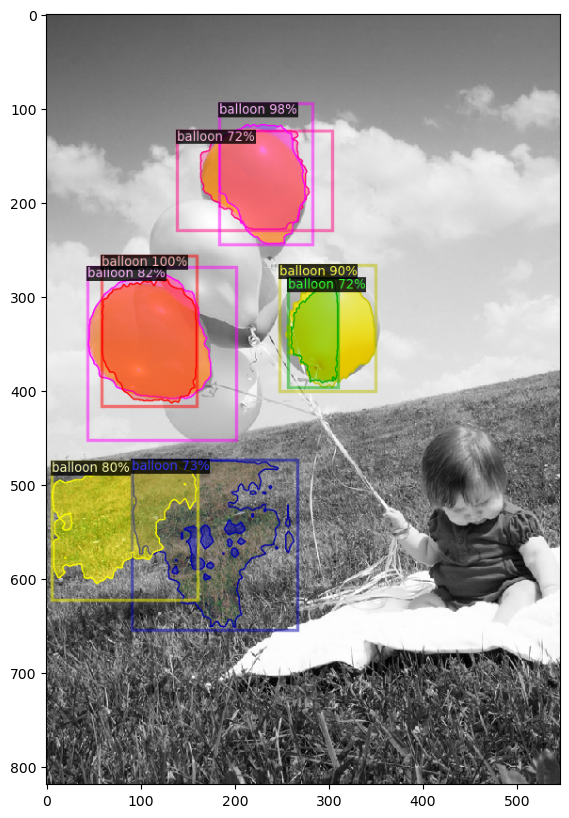

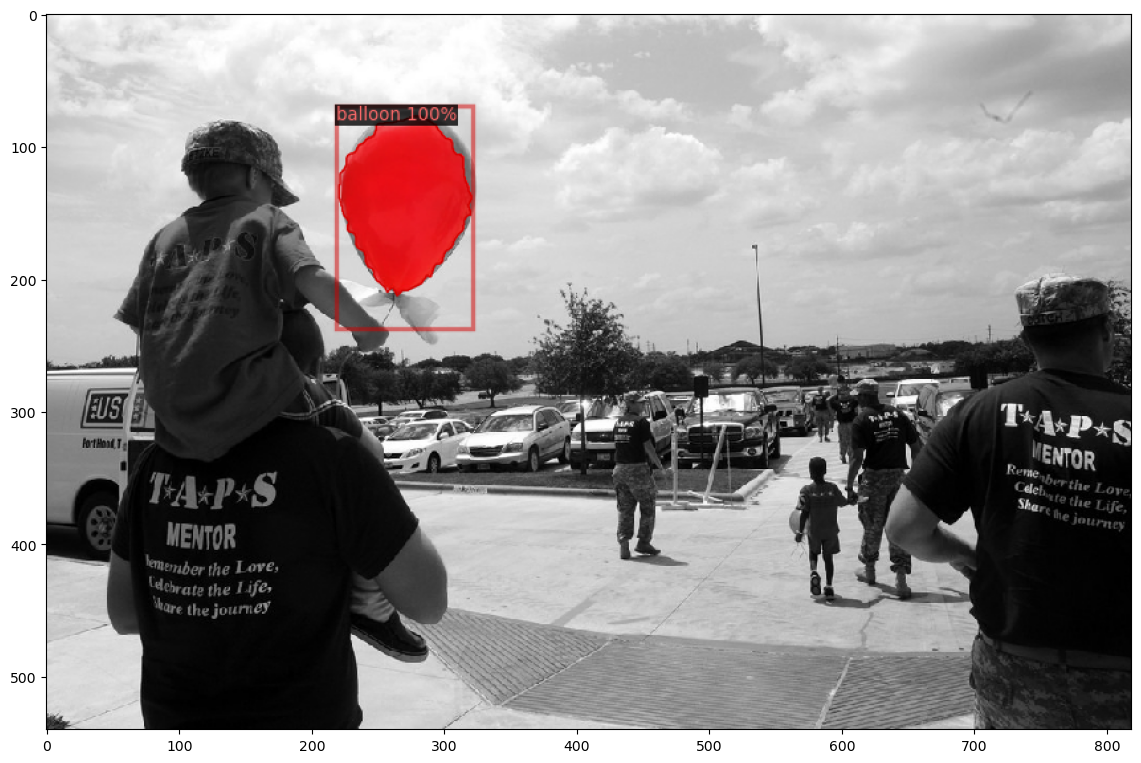

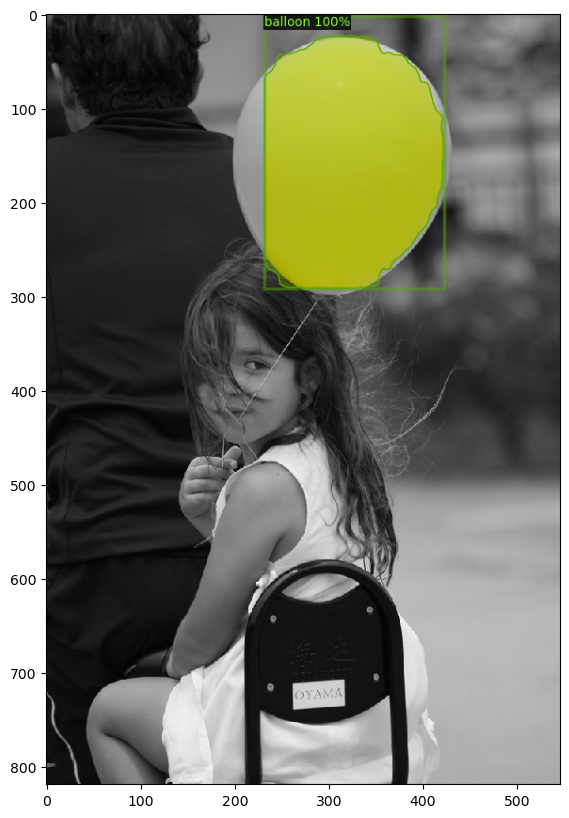

In [62]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_balloon_dicts("balloon/val")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=balloon_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()